In [1]:
%matplotlib notebook
from datetime import datetime
import glob
from eigsep_corr import io
import numpy as np
import matplotlib.pyplot as plt

In [2]:
DATA_DIR = "../../data_2024"
#files = sorted(glob.glob(f"{DATA_DIR}/20240722_1[4-8]*"))  # 2pm to 2:30 pacific time
files = sorted(glob.glob(f"{DATA_DIR}/20240721*"))  # 2pm to 2:30 pacific time
# corrupted files
files = np.array(files)
print(len(files))
hdr = io.read_header(files[0])
print(io.read_header(files[0]).keys())
freqs = np.linspace(0, hdr['sample_rate'] / 2, hdr['nchan'], endpoint=False)
hdr, data = io.read_file(files[0], header=hdr)
print(data.keys())
print(data['0'].shape)
acc_cnt = []
times = []
for i, f in enumerate(files):
    try:
        hdr = io.read_header(f)
    except:
        print(f)
        files = np.delete(files, i)
        continue
    acc_cnt.append(hdr['acc_cnt'])
    times.append(hdr['times'])
acc_cnt = np.concatenate(acc_cnt)
times = np.concatenate(times)

478
dict_keys(['dtype', 'infochan', 'nchan', 'acc_bins', 'fpg_file', 'fpg_version', 'sample_rate', 'gain', 'corr_acc_len', 'corr_scalar', 'pol01_delay', 'pam_atten', 'fft_shift', 'pairs', 'acc_cnt', 'sync_time', 'pol23_delay', 'pol45_delay', 'header_size', 'data_start', 'filename', 'filesize', 'nspec', 'freqs', 'dfreq', 'inttime', 'times'])
dict_keys(['0', '1', '2', '3', '4', '5', '02', '04', '24', '13', '15', '35'])
(60, 2, 1024, 1)
../../data_2024/20240721_174736.eig
../../data_2024/20240721_175617.eig
../../data_2024/20240721_180443.eig
../../data_2024/20240721_180635.eig


[226 291 303 308 309 310 311 322 338 346 350]


<IPython.core.display.Javascript object>


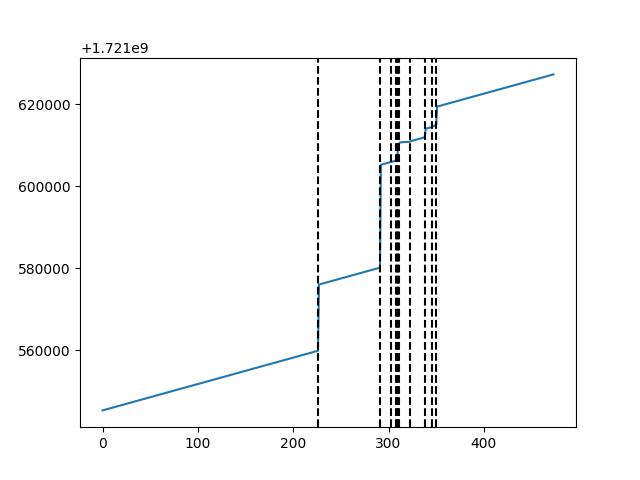

In [3]:
def fname2ts(f):
    t = f[-len("20231014_202203.eig"):-4]
    y = t[:4]
    mo = t[4:6]
    d = t[6:8]
    h = t[9:11]
    mi = t[11:13]
    s = t[13:15]
    dt = datetime.fromisoformat(f"{y}-{mo}-{d} {h}:{mi}:{s}")
    return dt.timestamp()

ftime = np.empty(len(files))
for i, f in enumerate(files):
    ftime[i] = fname2ts(f)
ix = np.argsort(ftime)
ftime = ftime[ix]
files = files[ix]

# observing stops when two files are far apart
breaks = np.argwhere(np.diff(ftime) > np.median(np.diff(ftime))+1)[:, 0]
print(breaks)

plt.figure()
plt.plot(ftime)
for b in breaks:
    plt.axvline(b, ls="--", c="k")
plt.show()

In [4]:
data = {}
cov = {}
wgt = {}
for f in files[:200]:
    hdr, dat = io.read_file(f)
    for k, d in dat.items():
#         if k not in ("2", "3", "4", "5", "24", "35"):
#             continue
        if len(k) == 1:
            d.dtype = io.build_dtype(np.uint32, '>')
        data[k] = data.get(k, []) + [d]
for k, v in data.items():
    data[k] = np.concatenate(v, axis=0)

In [5]:
freq = np.linspace(0, 250, num=1024)

<IPython.core.display.Javascript object>


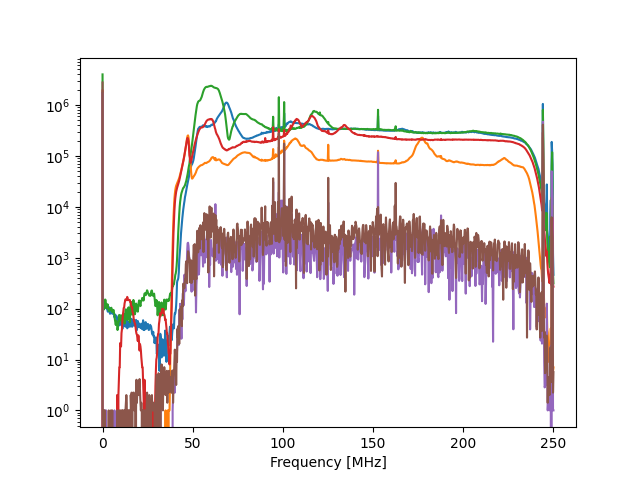

<IPython.core.display.Javascript object>


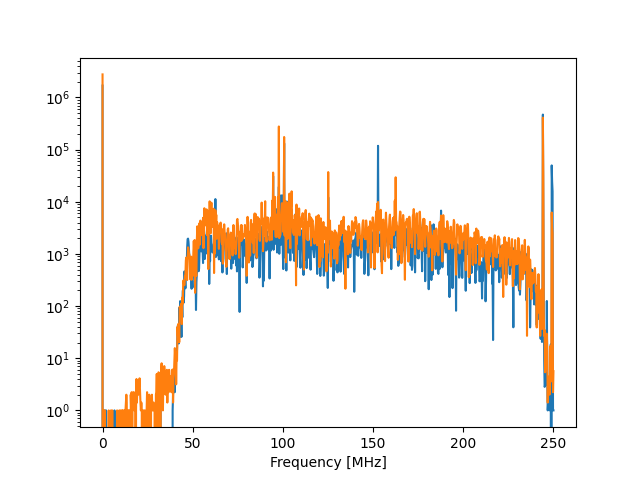

In [6]:
ix = 8080

plt.figure()
plt.semilogy(freq, data["0"][:, 0, :, 0][ix])
plt.semilogy(freq, data["2"][:, 0, :, 0][ix])
#plt.semilogy(freq, data["4"][:, 0, :, 0][ix])
plt.semilogy(freq, data["1"][:, 0, :, 0][ix])
plt.semilogy(freq, data["3"][:, 0, :, 0][ix])
#plt.semilogy(freq, data["5"][:, 0, :, 0][ix])
plt.semilogy(freq, np.abs(data["02"][:, 0, :, 0]+1j*data["02"][:, 0, :, 1])[ix])
plt.semilogy(freq, np.abs(data["13"][:, 0, :, 0]+1j*data["13"][:, 0, :, 1])[ix])

plt.xlabel("Frequency [MHz]")
plt.savefig("sample_spectrum.pdf", bbox_inches="tight")
plt.show()

plt.figure()
#plt.semilogy(freq, np.abs(data["24"][:, 0, :, 0]+1j*data["24"][:, 0, :, 1])[ix])
plt.semilogy(freq, np.abs(data["02"][:, 0, :, 0]+1j*data["02"][:, 0, :, 1])[ix])
plt.semilogy(freq, np.abs(data["13"][:, 0, :, 0]+1j*data["13"][:, 0, :, 1])[ix])
#plt.semilogy(freq, np.abs(data["35"][:, 0, :, 0]+1j*data["35"][:, 0, :, 1])[ix])
#plt.semilogy(freq, np.abs(data["15"][:, 0, :, 0]+1j*data["15"][:, 0, :, 1])[ix])
plt.xlabel("Frequency [MHz]")
plt.show()

In [7]:
import matplotlib.colors as colors
from datetime import datetime

In [11]:
import matplotlib.dates as mdates

<IPython.core.display.Javascript object>


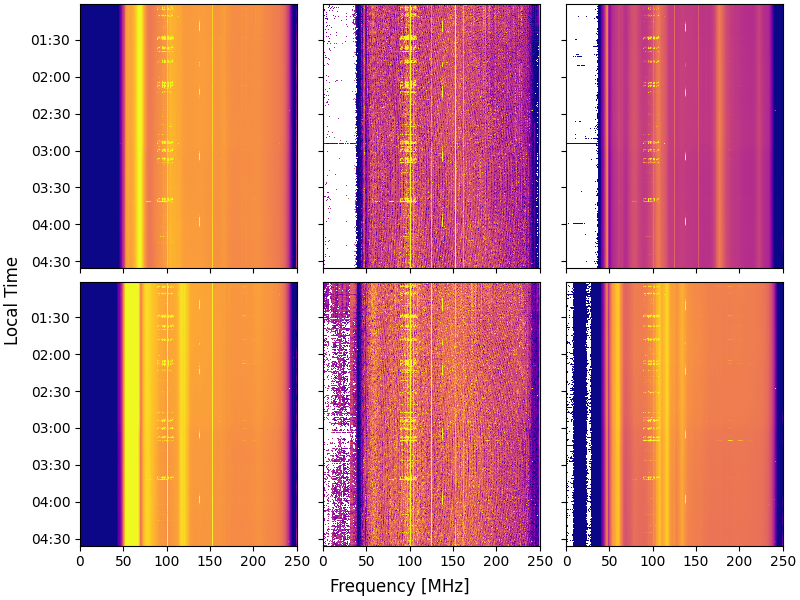

/tmp/ipykernel_65233/3376223652.py:19: RuntimeWarning: invalid value encountered in divide
  axs[i, 1].imshow(np.abs(data[k][:, 0, :, 0]+1j*data[k][:, 0, :, 1])/norm, norm=cross_ln, **kwargs)


In [16]:
tmin = datetime.fromtimestamp(ftime[0]+3600)
tmax = datetime.fromtimestamp(ftime[200]+3600)
extent = [0, 250, tmax, tmin]

# fig, axs = plt.subplots(ncols=2, sharex=True, sharey=True, constrained_layout=True)
# for i, k in enumerate(["2", "3"]):
#     axs[i].imshow(np.abs(data[k][:, 0, :, 0]), aspect="auto", norm=colors.LogNorm(vmin=1e4, vmax=1e6), cmap="plasma")
# plt.show()

fig, axs = plt.subplots(figsize=(8, 6), nrows=2, ncols=3, sharex=True, sharey=True, constrained_layout=True)
auto_ln = colors.LogNorm(vmin=1e4, vmax=1e6)
cross_ln = colors.LogNorm(vmin=1e-3, vmax=1e0)
kwargs = {"aspect": "auto", "cmap": "plasma", "extent": extent, "interpolation": "none"}
for i, k in enumerate(["02", "13"]):
    for j in range(2):
        d = np.abs(data[k[j]][:, 0, :, 0])
        axs[i, 2*j].imshow(d, norm=auto_ln, **kwargs)
    norm = np.sqrt(data[k[0]]**2 + data[k[1]]**2)[:, 0, :, 0]
    axs[i, 1].imshow(np.abs(data[k][:, 0, :, 0]+1j*data[k][:, 0, :, 1])/norm, norm=cross_ln, **kwargs)
axs[0, 0].yaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.supxlabel("Frequency [MHz]")
fig.supylabel("Local Time")
#plt.savefig("plots/waterfall_july21.p", bbox_inches="tight")
plt.show()

<IPython.core.display.Javascript object>


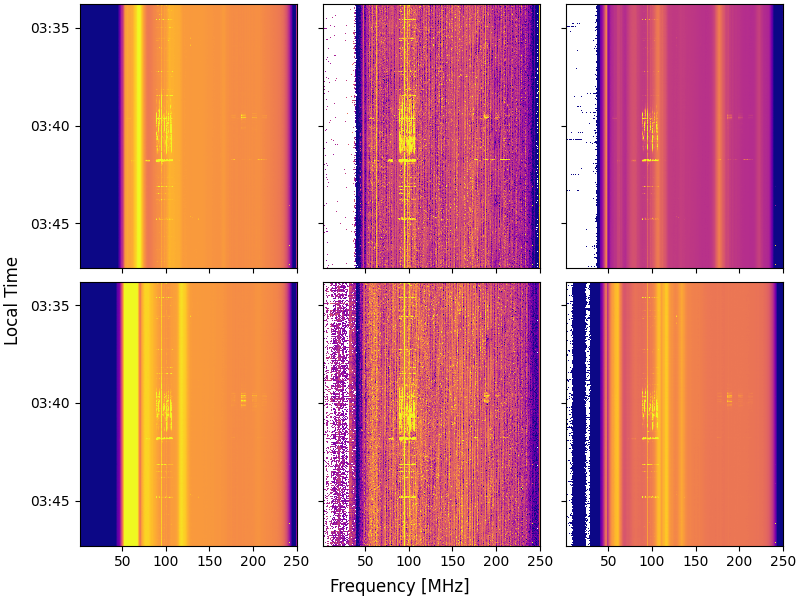

/tmp/ipykernel_65233/3898631817.py:10: RuntimeWarning: invalid value encountered in divide
  axs[i, 1].imshow(np.abs(data[k][:, 0, :, 0]+1j*data[k][:, 0, :, 1])/norm, norm=cross_ln, **kwargs)


In [17]:
fig, axs = plt.subplots(figsize=(8, 6), nrows=2, ncols=3, sharex=True, sharey=True, constrained_layout=True)
auto_ln = colors.LogNorm(vmin=1e4, vmax=1e6)
cross_ln = colors.LogNorm(vmin=1e-3, vmax=1e0)
kwargs = {"aspect": "auto", "cmap": "plasma", "extent": extent, "interpolation": "none"}
for i, k in enumerate(["02", "13"]):
    for j in range(2):
        d = np.abs(data[k[j]][:, 0, :, 0])
        axs[i, 2*j].imshow(d, norm=auto_ln, **kwargs)
    norm = np.sqrt(data[k[0]]**2 + data[k[1]]**2)[:, 0, :, 0]
    axs[i, 1].imshow(np.abs(data[k][:, 0, :, 0]+1j*data[k][:, 0, :, 1])/norm, norm=cross_ln, **kwargs)
axs[0, 0].yaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.supxlabel("Frequency [MHz]")
fig.supylabel("Local Time")
plt.show()

<IPython.core.display.Javascript object>


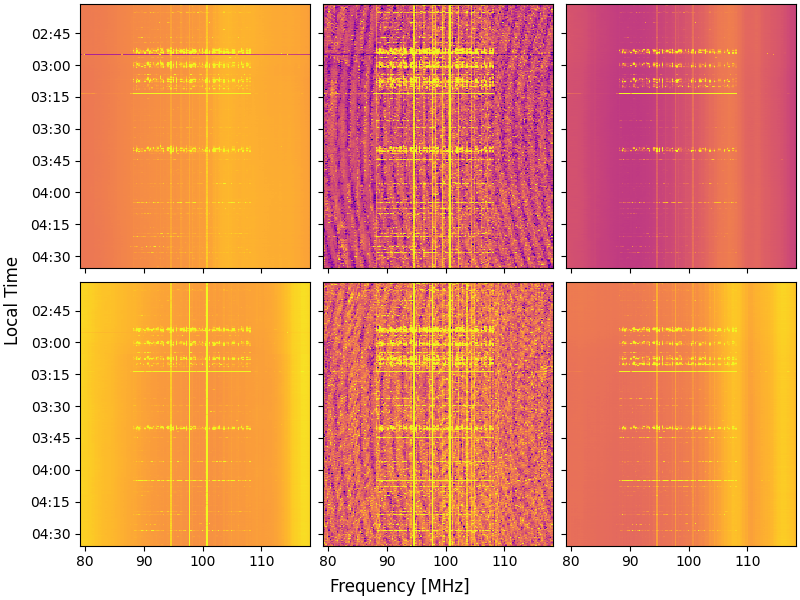

/tmp/ipykernel_65233/3898631817.py:10: RuntimeWarning: invalid value encountered in divide
  axs[i, 1].imshow(np.abs(data[k][:, 0, :, 0]+1j*data[k][:, 0, :, 1])/norm, norm=cross_ln, **kwargs)


In [18]:
fig, axs = plt.subplots(figsize=(8, 6), nrows=2, ncols=3, sharex=True, sharey=True, constrained_layout=True)
auto_ln = colors.LogNorm(vmin=1e4, vmax=1e6)
cross_ln = colors.LogNorm(vmin=1e-3, vmax=1e0)
kwargs = {"aspect": "auto", "cmap": "plasma", "extent": extent, "interpolation": "none"}
for i, k in enumerate(["02", "13"]):
    for j in range(2):
        d = np.abs(data[k[j]][:, 0, :, 0])
        axs[i, 2*j].imshow(d, norm=auto_ln, **kwargs)
    norm = np.sqrt(data[k[0]]**2 + data[k[1]]**2)[:, 0, :, 0]
    axs[i, 1].imshow(np.abs(data[k][:, 0, :, 0]+1j*data[k][:, 0, :, 1])/norm, norm=cross_ln, **kwargs)
axs[0, 0].yaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.supxlabel("Frequency [MHz]")
fig.supylabel("Local Time")
plt.show()

<IPython.core.display.Javascript object>


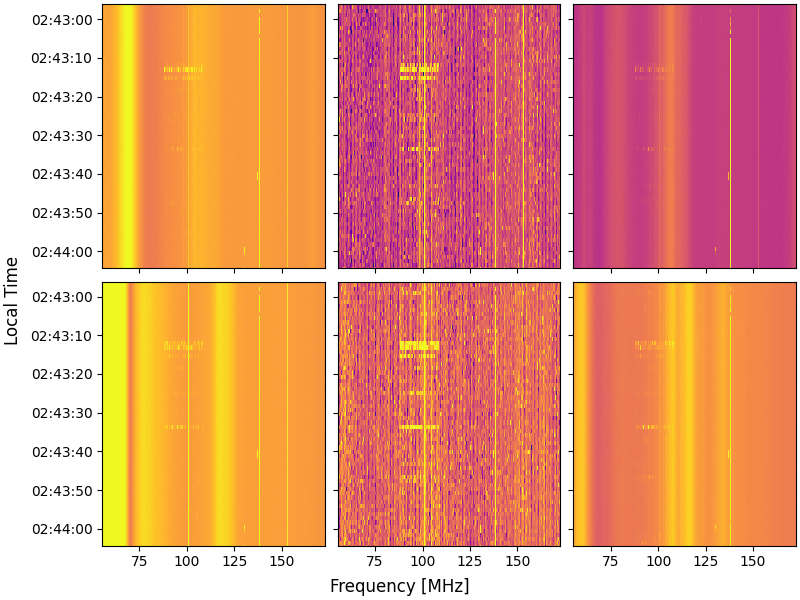

/tmp/ipykernel_65233/491571859.py:10: RuntimeWarning: invalid value encountered in divide
  axs[i, 1].imshow(np.abs(data[k][:, 0, :, 0]+1j*data[k][:, 0, :, 1])/norm, norm=cross_ln, **kwargs)


In [20]:
fig, axs = plt.subplots(figsize=(8, 6), nrows=2, ncols=3, sharex=True, sharey=True, constrained_layout=True)
auto_ln = colors.LogNorm(vmin=1e4, vmax=1e6)
cross_ln = colors.LogNorm(vmin=1e-3, vmax=1e0)
kwargs = {"aspect": "auto", "cmap": "plasma", "extent": extent, "interpolation": "none"}
for i, k in enumerate(["02", "13"]):
    for j in range(2):
        d = np.abs(data[k[j]][:, 0, :, 0])
        axs[i, 2*j].imshow(d, norm=auto_ln, **kwargs)
    norm = np.sqrt(data[k[0]]**2 + data[k[1]]**2)[:, 0, :, 0]
    axs[i, 1].imshow(np.abs(data[k][:, 0, :, 0]+1j*data[k][:, 0, :, 1])/norm, norm=cross_ln, **kwargs)
axs[0, 0].yaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
fig.supxlabel("Frequency [MHz]")
fig.supylabel("Local Time")
plt.show()